In [15]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tpu-getting-started/sample_submission.csv
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/09-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/14-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/01-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/13-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/00-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/07-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/12-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/11-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/05-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/04-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/15-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecord

In [16]:
import tensorflow as tf
import tensorflow_hub as hub

In [17]:
# Check if GPUs are available
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        # Set GPU memory growth to True to allocate GPU memory dynamically
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        strategy = tf.distribute.MirroredStrategy()  # Use MirroredStrategy for multi-GPU training
        print("Running on ", len(gpus), " GPU(s)")
    except RuntimeError as e:
        print(e)
        strategy = tf.distribute.get_strategy()  # Default strategy if GPUs are not available
else:
    strategy = tf.distribute.get_strategy()  # Default strategy if GPUs are not available

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on  2  GPU(s)
REPLICAS:  2


In [18]:
epochs = 30
image_size = 224
batch_size = 32
steps_per_epoch = 12753 / batch_size
lr = 3e-5
Auto = tf.data.experimental.AUTOTUNE

In [19]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32)/255
    image = tf.reshape(image, [image_size, image_size, 3])
    return image

def read_labeled_tfrecord(example):
    LABELED_TFRECORD_FORMAT = {
        "image" : tf.io.FixedLenFeature([], tf.string),
        "class" : tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example, LABELED_TFRECORD_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label

def read_unlabeled_tfrecord(example):
    UNLABELED_TFRECORD_FORMAT = {
        "image" : tf.io.FixedLenFeature([], tf.string),
        "id" : tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFRECORD_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum

def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    
    if not ordered:
        ignore_order.experimental_deterministic = False
    
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord)
    
    return dataset

def data_augumentation(image, label):
    image_aug = tf.image.random_brightness(image, 0.3)
    image_aug = tf.image.random_contrast(image_aug, 0.3, 0.7)
    image_aug = tf.image.random_flip_left_right(image_aug)
    image_aug = tf.image.random_flip_up_down(image_aug)
    image_aug = tf.image.random_hue(image_aug, 0.3)
    image_aug = tf.image.adjust_gamma(image_aug, 0.3)
    image_aug = tf.image.random_saturation(image_aug, 0.3, 0.7)
    return image_aug, label

def get_training_dataset():
    dataset = load_dataset(tf.io.gfile.glob('/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/train/*.tfrec'), labeled=True)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size)
    return dataset

def get_training_dataset_aug():
    dataset = load_dataset(tf.io.gfile.glob('/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/train/*.tfrec'), labeled=True)
    dataset = dataset.map(data_augumentation, num_parallel_calls=Auto)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(tf.io.gfile.glob('/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/*.tfrec'), labeled=True, ordered=False)
    dataset = dataset.batch(batch_size)
    dataset = dataset.cache()
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(tf.io.gfile.glob('/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/test/*.tfrec'), labeled=False, ordered=ordered)
    dataset = dataset.batch(batch_size)
    return dataset

In [20]:
training_dataset = get_training_dataset()
aug_training_dataset = get_training_dataset_aug()
train_dataset_augmented = training_dataset.concatenate(aug_training_dataset)
validation_dataset = get_validation_dataset()
test_dataset = get_test_dataset(ordered=True)

In [21]:
def scheduler(epoch):
    global lr
    if epoch<10:
        lr += 1e-5
        return lr
    else:
        lr = lr * tf.math.exp(-0.1)
        return lr

callback = tf.keras.callbacks.LearningRateScheduler(
    scheduler,
    verbose = 1
)

Learning rate schedule: 4e-05 to 0.00013 to 1.76e-05


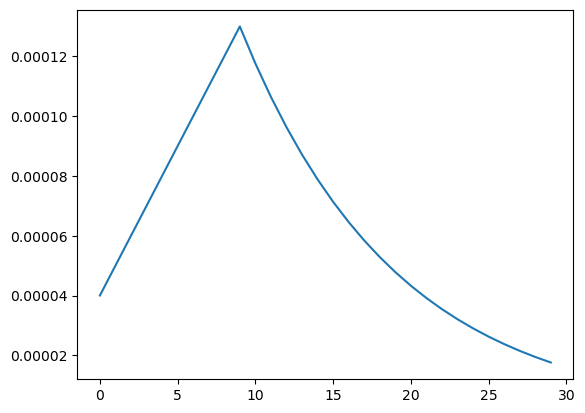

In [22]:
from matplotlib import pyplot as plt

rng = [i for i in range(epochs)]
y = [scheduler(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [23]:
pretrained_model = tf.keras.applications.DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape = (image_size, image_size, 3),
)
pretrained_model.trainable = True

model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(104, activation='softmax')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d_2   (None, 1920)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 104)               199784    
                                                                 
Total params: 18,521,768
Trainable params: 18,292,712
Non-trainable params: 229,056
_________________________________________________________________


In [24]:
model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['sparse_categorical_accuracy']
)

history = model.fit(
    train_dataset_augmented,
    steps_per_epoch = steps_per_epoch,
    callbacks = [callback],
    epochs = epochs,
    validation_data = validation_dataset
)


Epoch 1: LearningRateScheduler setting learning rate to 2.759357084869407e-05.
Epoch 1/30
398/398 [==============================] - 360s 586ms/step - loss: 2.3048 - sparse_categorical_accuracy: 0.5276 - val_loss: 1.0462 - val_sparse_categorical_accuracy: 0.7845 - lr: 2.7594e-05

Epoch 2: LearningRateScheduler setting learning rate to 3.759357059607282e-05.
Epoch 2/30
398/398 [==============================] - 230s 577ms/step - loss: 0.7111 - sparse_categorical_accuracy: 0.8579 - val_loss: 0.5509 - val_sparse_categorical_accuracy: 0.8823 - lr: 3.7594e-05

Epoch 3: LearningRateScheduler setting learning rate to 4.7593570343451574e-05.
Epoch 3/30
398/398 [==============================] - 230s 578ms/step - loss: 0.2957 - sparse_categorical_accuracy: 0.9499 - val_loss: 0.4184 - val_sparse_categorical_accuracy: 0.9027 - lr: 4.7594e-05

Epoch 4: LearningRateScheduler setting learning rate to 5.7593570090830326e-05.
Epoch 4/30
398/398 [==============================] - 230s 577ms/step - los

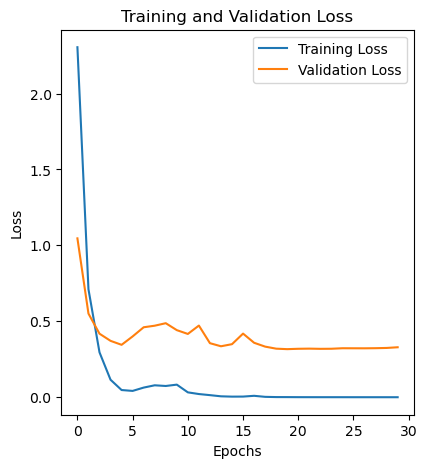

In [25]:
import matplotlib.pyplot as plt

# Assuming you've trained the model and stored the history in the 'history' variable

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()




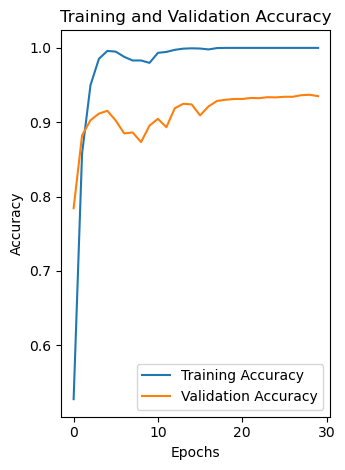

In [26]:
# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [27]:
final_training_loss = history.history['loss'][-1]
final_validation_loss = history.history['val_loss'][-1]

print(f"Final Training Loss: {final_training_loss}")
print(f"Final Validation Loss: {final_validation_loss}")

Final Training Loss: 0.00015436824469361454
Final Validation Loss: 0.3291207253932953


In [28]:
# Access the final training and validation accuracy values
final_training_accuracy = history.history['sparse_categorical_accuracy'][-1] * 100
final_validation_accuracy = history.history['val_sparse_categorical_accuracy'][-1] * 100

print(f"Final Training Accuracy: {final_training_accuracy:.2f}%")
print(f"Final Validation Accuracy: {final_validation_accuracy:.2f}%")


Final Training Accuracy: 100.00%
Final Validation Accuracy: 93.51%


In [29]:
test_images_ds = test_dataset.map(lambda image, idnum: image)
probabilities = model.predict(test_images_ds)
predictions = np.argmax(probabilities, axis=-1)
print(predictions)

231/231 [==============================] - 38s 150ms/step
[ 46  73   9 ...  53  41 102]


In [30]:
test_ids_ds = test_dataset.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(7382))).numpy().astype('U') # all in one batch
np.savetxt('submission.csv', np.rec.fromarrays([test_ids, predictions]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')

In [31]:
CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102

In [39]:
import math

In [40]:
dataset = get_validation_dataset()
dataset = dataset.unbatch().batch(20)
batch = iter(dataset)

In [48]:
def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)

In [49]:
def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case,
                                     # these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is
    # the case for test data)
    return numpy_images, numpy_labels

In [50]:
def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square
    # or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

1/1 [==============================] - 0s 48ms/step


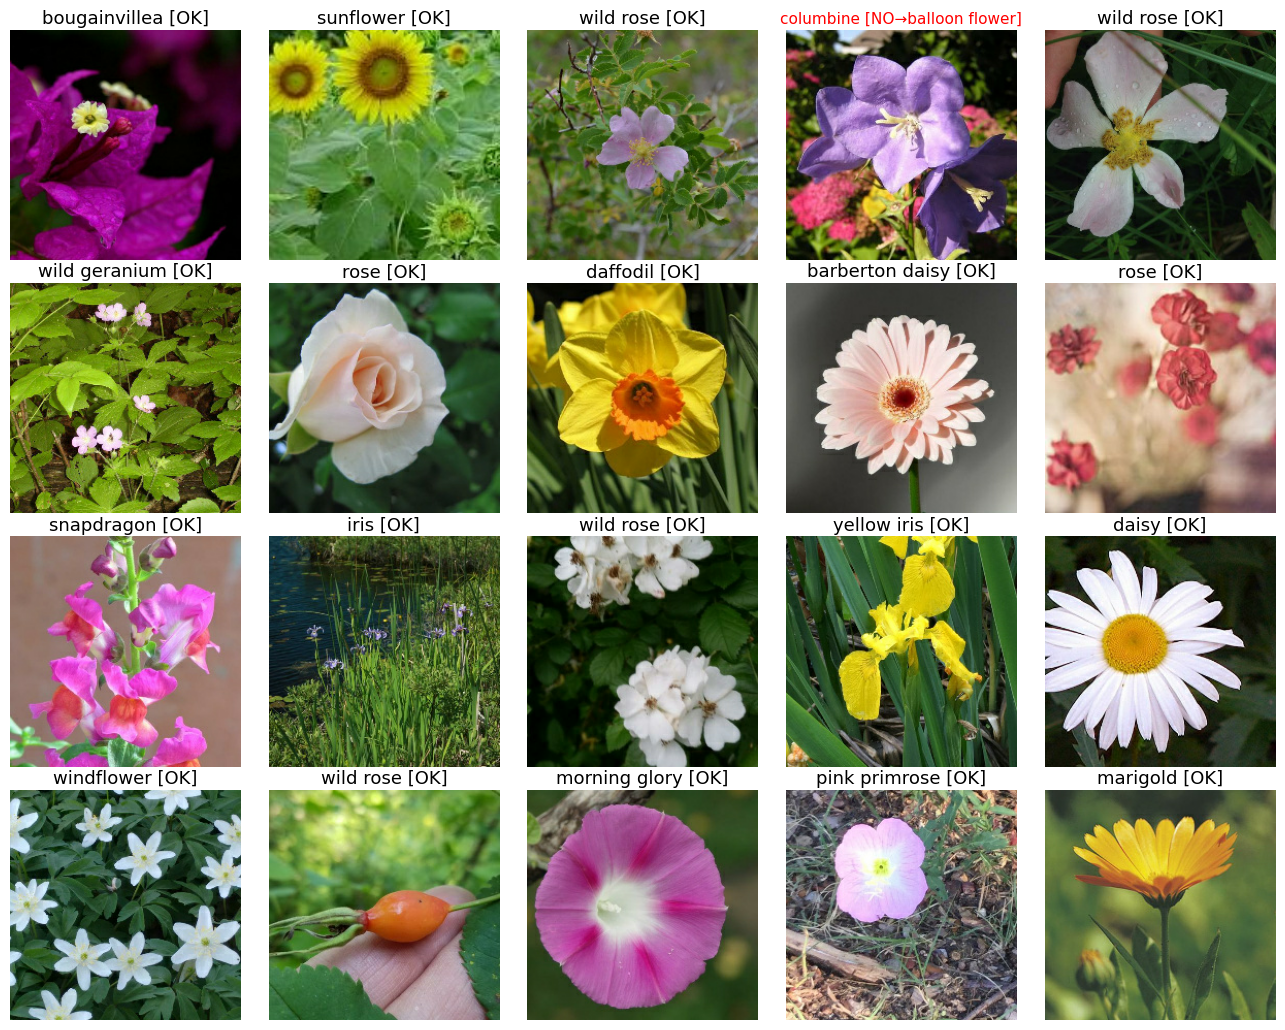

In [51]:
images, labels = next(batch)
probabilities = model.predict(images)
predictions = np.argmax(probabilities, axis=-1)
display_batch_of_images((images, labels), predictions)